In [1]:
#%matplotlib widget

import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import auxFuncs as aux
import HbXConcentrations as hbx
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import zoom

In [2]:
# Load sample MC simulations

imagesMC1_Sep1, shapeImagesMC1_Sep1 = aux.loadMatStruct("DosInc_reg_660_sep15_sinPared.mat", "flux")
imagesMC2_Sep1, shapeImagesMC2_Sep1 = aux.loadMatStruct("DosInc_reg_830_sep15_sinPared.mat", "flux")

imagesMC1_Sep2, shapeImagesMC1_Sep2 = aux.loadMatStruct("DosInc_reg_660_sep20_sinPared.mat", "flux")
imagesMC2_Sep2, shapeImagesMC2_Sep2 = aux.loadMatStruct("DosInc_reg_830_sep20_sinPared.mat", "flux")

imagesMC1_Sep3, shapeImagesMC1_Sep3 = aux.loadMatStruct("DosInc_reg_660_sep25_sinPared.mat", "flux")
imagesMC2_Sep3, shapeImagesMC2_Sep3 = aux.loadMatStruct("DosInc_reg_830_sep25_sinPared.mat", "flux")

In [3]:
# Load ground truths for SSIM comparison

GTHbO_Sep1 = np.loadtxt("groundTruth_HbO_sep15_sinPared.txt", delimiter=",")
GTHbR_Sep1 = np.loadtxt("groundTruth_HbR_sep15_sinPared.txt", delimiter=",")

GTHbO_Sep2 = np.loadtxt("groundTruth_HbO_sep20_sinPared.txt", delimiter=",")
GTHbR_Sep2 = np.loadtxt("groundTruth_HbR_sep20_sinPared.txt", delimiter=",")

GTHbO_Sep3 = np.loadtxt("groundTruth_HbO_sep25_sinPared.txt", delimiter=",")
GTHbR_Sep3 = np.loadtxt("groundTruth_HbR_sep25_sinPared.txt", delimiter=",")

basalHbO_Sep1 = GTHbO_Sep1[0,0]
basalHbR_Sep1 = GTHbR_Sep1[0,0]
GTHbO_Sep1[GTHbO_Sep1==basalHbO_Sep1] = 0
GTHbR_Sep1[GTHbR_Sep1==basalHbR_Sep1] = 0

basalHbO_Sep2 = GTHbO_Sep2[0,0]
basalHbR_Sep2 = GTHbR_Sep2[0,0]
GTHbO_Sep2[GTHbO_Sep2==basalHbO_Sep2] = 0
GTHbR_Sep2[GTHbR_Sep2==basalHbR_Sep2] = 0

basalHbO_Sep3 = GTHbO_Sep3[0,0]
basalHbR_Sep3 = GTHbR_Sep3[0,0]
GTHbO_Sep3[GTHbO_Sep3==basalHbO_Sep3] = 0
GTHbR_Sep3[GTHbR_Sep3==basalHbR_Sep3] = 0


In [4]:
sigmaGauss = 12
fftStrength = 2
cropSizeX = 70
cropSizeY = 70
maxDev = 10
doTotMap = False
doSatMap = True

# Separation  1

In [5]:
# Perfom smoothing

for i in range(shapeImagesMC1_Sep1[0]):
    imagesMC1_Sep1[i] = aux.fftGauss(imagesMC1_Sep1[i], fftStrength)[0]
    
for i in range(shapeImagesMC2_Sep1[0]):
    imagesMC2_Sep1[i] = aux.fftGauss(imagesMC2_Sep1[i], fftStrength)[0]

/home/nicolas/Bionirs/MamoRefCodePublic/auxFuncs.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  im_output[~in_NaNs] = im_filtered[~in_NaNs]


In [6]:
# Compute source centers

centersPos1 = np.empty((shapeImagesMC1_Sep2[0],2))
centersPos2 = np.empty((shapeImagesMC2_Sep2[0],2))

for i in range(shapeImagesMC1_Sep2[0]):
    centersPos1[i] = aux.maxPosCm(imagesMC1_Sep2[i], smooth=0)
    
for i in range(shapeImagesMC2_Sep2[0]):
    centersPos2[i] = aux.maxPosCm(imagesMC2_Sep2[i], smooth=0)

In [7]:
# Compute centered crops

imagesCentered1 = []
imagesCentered2 = []

for i, image in enumerate(imagesMC1_Sep1):
    imageTemp = aux.cropAroundPosition(image, round(centersPos1[i][1]), round(centersPos1[i][0]), cropSizeX, cropSizeY) 
    imagesCentered1.append(imageTemp) 

for i, image in enumerate(imagesMC2_Sep1):
    imageTemp = aux.cropAroundPosition(image, round(centersPos2[i][1]), round(centersPos2[i][0]), cropSizeX, cropSizeY) 
    imagesCentered2.append(imageTemp)  

In [8]:
# Generate background normalization image
back1 = np.nanmean(imagesCentered1, axis=0)
back2 = np.nanmean(imagesCentered2, axis=0)

In [9]:
# Compute normalized crops
imagesDiv1 = imagesCentered1/back1
imagesDiv2 = imagesCentered2/back2

In [10]:
# Generate 2D reconstruction using gaussian weights

gaussianWeights = aux.gaussian2D(cropSizeX,cropSizeY,int(cropSizeX/2),int(cropSizeX/2),sigma=sigmaGauss,muu=0,contrast=0)

recon2DAll1, recon2DAllCount1 = aux.recon2D(imagesDiv1, centersPos1, weights=gaussianWeights)
recon2DAll2, recon2DAllCount2 = aux.recon2D(imagesDiv2, centersPos2, weights=gaussianWeights)

#recon2DAll1, recon2DAllCount1 = aux.recon2D(imagesDiv1, centersPos1)
#recon2DAll2, recon2DAllCount2 = aux.recon2D(imagesDiv2, centersPos2)


36it [00:00, 75.79it/s]
/home/nicolas/Bionirs/MamoRefCodePublic/auxFuncs.py:233: RuntimeWarning: invalid value encountered in divide
  imageRecon = imageReconTemp/imageReconCount
36it [00:00, 79.80it/s]


In [11]:
offsetX = 250 - np.shape(recon2DAll1)[0]
offsetY = 250 - np.shape(recon2DAll1)[1]

In [12]:
minValPos = 15

extent = [minValPos , 250, 250, minValPos]

recon2DCrop1 = recon2DAll1[minValPos:,minValPos:]
recon2DCrop2 = recon2DAll2[minValPos:,minValPos:]

In [13]:
imRaw = np.zeros((np.shape(recon2DCrop1)[0], np.shape(recon2DCrop1)[1], 2))
imRaw[:,:,0] = recon2DCrop1
imRaw[:,:,1] = recon2DCrop2

lambdas = [660, 830]

cropSize = 100

HbXMaps_2D = hbx.MamoRef_dHbX(imRaw, lambdas, centersPos1, cropSize, cropSize)
    
desOxyMap_2D_Sep1 = HbXMaps_2D[:,:,1]
OxyMap_2D_Sep1 = HbXMaps_2D[:,:,0]
TotMap_2D_Sep1 = desOxyMap_2D_Sep1 + OxyMap_2D_Sep1

Step 1/2...


100%|██████████| 100/100 [00:06<00:00, 15.38it/s]


Step 2/2...


100%|██████████| 36/36 [00:11<00:00,  3.05it/s]
/home/nicolas/Bionirs/MamoRefCodePublic/HbXConcentrations.py:162: RuntimeWarning: invalid value encountered in divide
  LL = LL/cont


In [14]:
#desOxyMap_2D_filtered = ndimage.median_filter(desOxyMap_2D,0)
#OxyMap_2D_filtered = ndimage.median_filter(OxyMap_2D,0)

desOxyMap_2D_filtered_Sep1 = desOxyMap_2D_Sep1
OxyMap_2D_filtered_Sep1 = OxyMap_2D_Sep1

desOxyMap_2D_filtered_Sep1[desOxyMap_2D_filtered_Sep1==np.nan] = 0
OxyMap_2D_filtered_Sep1[OxyMap_2D_filtered_Sep1==np.nan] = 0

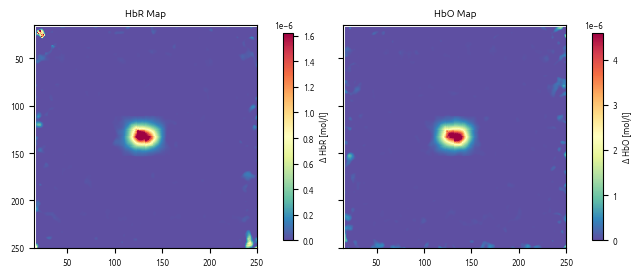

In [15]:
colorMap = "Spectral_r"
    
font = {'family' : 'ubuntu',
        'weight' : 'regular',
        'size'   : 6}

mp.rc('font', **font)


if doTotMap:
        figSats, ((DesOxy, Oxy, Tot)) = plt.subplots(1, 3, sharex=True, sharey=True)
        font["size"] = 6
        mp.rc('font', **font)
else:
        figSats, ((DesOxy,Oxy)) = plt.subplots(1, 2, sharex=True, sharey=True)

sd = np.nanstd(desOxyMap_2D_filtered_Sep1)
median = np.nanmedian(desOxyMap_2D_filtered_Sep1)
vmax = median + maxDev * sd
vmin = 0

figDesOxy = DesOxy.imshow(desOxyMap_2D_filtered_Sep1, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c1 = figSats.colorbar(figDesOxy, ax=DesOxy, fraction=0.04, pad=0.1)
c1.set_label("Δ HbR [mol/l]")

sd = np.nanstd(OxyMap_2D_filtered_Sep1)
median = np.nanmedian(OxyMap_2D_filtered_Sep1)
vmax = median + maxDev * sd
vmin = 0


figOxy = Oxy.imshow(OxyMap_2D_filtered_Sep1, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c2 = figSats.colorbar(figOxy, ax=Oxy, fraction=0.04, pad=0.1)
c2.set_label("Δ HbO [mol/l]")


if doTotMap:
        TotMap_2D_Sep1 = desOxyMap_2D_filtered_Sep1 + OxyMap_2D_filtered_Sep1

        sd = np.nanstd(TotMap_2D_Sep1)
        median = np.nanmedian(TotMap_2D_Sep1)
        vmax = median + maxDev * sd
        vmin = 0


        figTot = Tot.imshow(TotMap_2D_Sep1, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
        c3 = figSats.colorbar(figTot, ax=Tot, fraction=0.04, pad=0.1)
        c3.set_label("Δ HbTot [mol/l]")

        Tot.set_title("Total HB HBMap")


DesOxy.set_title("HbR Map")

Oxy.set_title("HbO Map")

figSats.tight_layout()

figSats.savefig("MC2Incs_HbXMaps_MultiSep_Sep1.png", dpi=300)

0.8624080502735956 0.8781936371992419


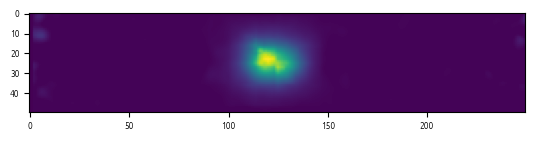

In [16]:
desOxyMap_2D_scaled_Sep1 = zoom(desOxyMap_2D_filtered_Sep1, 250/np.shape(desOxyMap_2D_filtered_Sep1)[0], order=1)
OxyMap_2D_scaled_Sep1= zoom(OxyMap_2D_filtered_Sep1, 250/np.shape(OxyMap_2D_filtered_Sep1)[0], order=1)

desOxyMap_2D_scaled_Sep1[desOxyMap_2D_scaled_Sep1<0]=0
desOxyMap_2D_scaled_Sep1[np.isnan(desOxyMap_2D_scaled_Sep1)]=np.nanmean(desOxyMap_2D_filtered_Sep1)

OxyMap_2D_scaled_Sep1[OxyMap_2D_scaled_Sep1<0]=0
OxyMap_2D_scaled_Sep1[np.isnan(OxyMap_2D_scaled_Sep1)]=np.nanmean(OxyMap_2D_filtered_Sep1)

plt.imshow(desOxyMap_2D_scaled_Sep1[100:150,:])

ssimOxy_Sep1 = ssim(GTHbO_Sep1[100:150,:], OxyMap_2D_scaled_Sep1[100:150,:], data_range=np.max(GTHbO_Sep1) - np.min(GTHbO_Sep1))
ssimDesOxy_Sep1 = ssim(GTHbR_Sep1[100:150,:], desOxyMap_2D_scaled_Sep1[100:150,:], data_range=np.max(GTHbR_Sep1) - np.min(GTHbR_Sep1))

ssimOxy_Sep1 = ssim(GTHbO_Sep1[100:150,:], OxyMap_2D_scaled_Sep1[100:150,:], data_range=np.max(GTHbO_Sep1) - np.min(GTHbO_Sep1))
ssimDesOxy_Sep1 = ssim(GTHbR_Sep1[100:150,:], desOxyMap_2D_scaled_Sep1[100:150,:], data_range=np.max(GTHbR_Sep1) - np.min(GTHbR_Sep1))

print(ssimOxy_Sep1, ssimDesOxy_Sep1)


# Separation  2

In [17]:
# Perfom smoothing

for i in range(shapeImagesMC1_Sep2[0]):
    imagesMC1_Sep2[i] = aux.fftGauss(imagesMC1_Sep2[i], fftStrength)[0]
    
for i in range(shapeImagesMC2_Sep2[0]):
    imagesMC2_Sep2[i] = aux.fftGauss(imagesMC2_Sep2[i], fftStrength)[0]

In [18]:
# Compute source centers

centersPos1 = np.empty((shapeImagesMC1_Sep2[0],2))
centersPos2 = np.empty((shapeImagesMC2_Sep2[0],2))

for i in range(shapeImagesMC1_Sep2[0]):
    centersPos1[i] = aux.maxPosCm(imagesMC1_Sep2[i], smooth=0)
    
for i in range(shapeImagesMC2_Sep2[0]):
    centersPos2[i] = aux.maxPosCm(imagesMC2_Sep2[i], smooth=0)

In [19]:
# Compute centered crops

imagesCentered1 = []
imagesCentered2 = []

for i, image in enumerate(imagesMC1_Sep2):
    imageTemp = aux.cropAroundPosition(image, round(centersPos1[i][1]), round(centersPos1[i][0]), cropSizeX, cropSizeY) 
    imagesCentered1.append(imageTemp) 

for i, image in enumerate(imagesMC2_Sep2):
    imageTemp = aux.cropAroundPosition(image, round(centersPos2[i][1]), round(centersPos2[i][0]), cropSizeX, cropSizeY) 
    imagesCentered2.append(imageTemp)  

In [20]:
# Generate background normalization image
back1 = np.nanmean(imagesCentered1, axis=0)
back2 = np.nanmean(imagesCentered2, axis=0)

In [21]:
# Compute normalized crops
imagesDiv1 = imagesCentered1/back1
imagesDiv2 = imagesCentered2/back2

In [22]:
# Generate 2D reconstruction using gaussian weights

gaussianWeights = aux.gaussian2D(cropSizeX,cropSizeY,int(cropSizeX/2),int(cropSizeX/2),sigma=sigmaGauss,muu=0,contrast=0)

recon2DAll1, recon2DAllCount1 = aux.recon2D(imagesDiv1, centersPos1, weights=gaussianWeights)
recon2DAll2, recon2DAllCount2 = aux.recon2D(imagesDiv2, centersPos2, weights=gaussianWeights)

36it [00:00, 73.09it/s]
36it [00:00, 75.92it/s]


In [23]:
offsetX = 250 - np.shape(recon2DAll1)[0]
offsetY = 250 - np.shape(recon2DAll1)[1]

In [24]:
minValPos = 15
extent = [minValPos , 250, 250, minValPos]

recon2DCrop1 = recon2DAll1[minValPos:,minValPos:]
recon2DCrop2 = recon2DAll2[minValPos:,minValPos:]

In [25]:
imRaw = np.zeros((np.shape(recon2DCrop1)[0], np.shape(recon2DCrop1)[1], 2))
imRaw[:,:,0] = recon2DCrop1
imRaw[:,:,1] = recon2DCrop2

lambdas = [660, 830]

cropSize = 100

HbXMaps_2D = hbx.MamoRef_dHbX(imRaw, lambdas, centersPos1, cropSize, cropSize)
    
desOxyMap_2D_Sep2 = HbXMaps_2D[:,:,1]
OxyMap_2D_Sep2 = HbXMaps_2D[:,:,0]
TotMap_2D_Sep2 = desOxyMap_2D_Sep2 + OxyMap_2D_Sep2

Step 1/2...


100%|██████████| 100/100 [00:06<00:00, 15.55it/s]


Step 2/2...


100%|██████████| 36/36 [00:11<00:00,  3.07it/s]


In [26]:
#desOxyMap_2D_filtered = ndimage.median_filter(desOxyMap_2D,0)
#OxyMap_2D_filtered = ndimage.median_filter(OxyMap_2D,0)

desOxyMap_2D_filtered_Sep2 = desOxyMap_2D_Sep2
OxyMap_2D_filtered_Sep2 = OxyMap_2D_Sep2

desOxyMap_2D_filtered_Sep2[desOxyMap_2D_filtered_Sep2==np.nan] = 0
OxyMap_2D_filtered_Sep2[OxyMap_2D_filtered_Sep2==np.nan] = 0

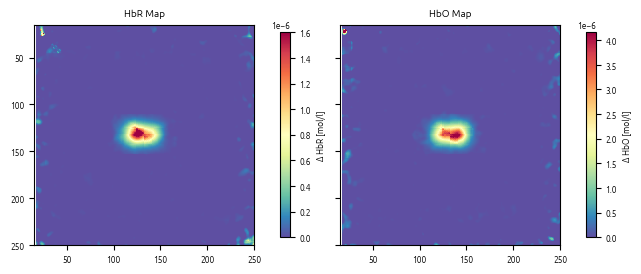

In [27]:
colorMap = "Spectral_r"
    
font = {'family' : 'ubuntu',
        'weight' : 'regular',
        'size'   : 6}

mp.rc('font', **font)

if doTotMap:
        figSats, ((DesOxy, Oxy, Tot)) = plt.subplots(1, 3, sharex=True, sharey=True)
        font["size"] = 6
        mp.rc('font', **font)
else:
        figSats, ((DesOxy,Oxy)) = plt.subplots(1, 2, sharex=True, sharey=True)

sd = np.nanstd(desOxyMap_2D_filtered_Sep2)
median = np.nanmedian(desOxyMap_2D_filtered_Sep2)
vmax = median + maxDev * sd
vmin = 0

figDesOxy = DesOxy.imshow(desOxyMap_2D_filtered_Sep2, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c1 = figSats.colorbar(figDesOxy, ax=DesOxy, fraction=0.04, pad=0.1)
c1.set_label("Δ HbR [mol/l]")

sd = np.nanstd(OxyMap_2D_filtered_Sep2)
median = np.nanmedian(OxyMap_2D_filtered_Sep2)
vmax = median + maxDev * sd
vmin = 0


figOxy = Oxy.imshow(OxyMap_2D_filtered_Sep2, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c2 = figSats.colorbar(figOxy, ax=Oxy, fraction=0.04, pad=0.1)
c2.set_label("Δ HbO [mol/l]")

if doTotMap:
        TotMap_2D_Sep2 = desOxyMap_2D_filtered_Sep2 + OxyMap_2D_filtered_Sep2

        sd = np.nanstd(TotMap_2D_Sep2)
        median = np.nanmedian(TotMap_2D_Sep2)
        vmax = median + maxDev * sd
        vmin = 0


        figTot = Tot.imshow(TotMap_2D_Sep2, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
        c3 = figSats.colorbar(figTot, ax=Tot, fraction=0.04, pad=0.1)
        c3.set_label("Δ HbTot [mol/l]")

        Tot.set_title("Total HB HBMap")


DesOxy.set_title("HbR Map")

Oxy.set_title("HbO Map")

figSats.tight_layout()

figSats.savefig("MC2Incs_HbXMaps_MultiSep_Sep2.png", dpi=300)

0.8412217279319666 0.8601942965729236


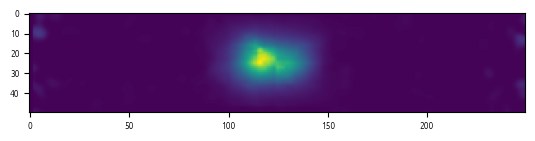

In [28]:
desOxyMap_2D_scaled_Sep2 = zoom(desOxyMap_2D_filtered_Sep2, 250/np.shape(desOxyMap_2D_filtered_Sep2)[0], order=1)
OxyMap_2D_scaled_Sep2= zoom(OxyMap_2D_filtered_Sep2, 250/np.shape(OxyMap_2D_filtered_Sep2)[0], order=1)

desOxyMap_2D_scaled_Sep2[desOxyMap_2D_scaled_Sep2<0]=0
desOxyMap_2D_scaled_Sep2[np.isnan(desOxyMap_2D_scaled_Sep2)]=np.nanmean(desOxyMap_2D_filtered_Sep2)

OxyMap_2D_scaled_Sep2[OxyMap_2D_scaled_Sep2<0]=0
OxyMap_2D_scaled_Sep2[np.isnan(OxyMap_2D_scaled_Sep2)]=np.nanmean(OxyMap_2D_filtered_Sep2)

plt.imshow(desOxyMap_2D_scaled_Sep2[100:150,:])

ssimOxy_Sep2 = ssim(GTHbO_Sep2[100:150,:], OxyMap_2D_scaled_Sep2[100:150,:], data_range=np.max(GTHbO_Sep2) - np.min(GTHbO_Sep2))
ssimDesOxy_Sep2 = ssim(GTHbR_Sep2[100:150,:], desOxyMap_2D_scaled_Sep2[100:150,:], data_range=np.max(GTHbR_Sep2) - np.min(GTHbR_Sep2))

ssimOxy_Sep2 = ssim(GTHbO_Sep2[100:150,:], OxyMap_2D_scaled_Sep2[100:150,:], data_range=np.max(GTHbO_Sep2) - np.min(GTHbO_Sep2))
ssimDesOxy_Sep2 = ssim(GTHbR_Sep2[100:150,:], desOxyMap_2D_scaled_Sep2[100:150,:], data_range=np.max(GTHbR_Sep2) - np.min(GTHbR_Sep2))

print(ssimOxy_Sep2, ssimDesOxy_Sep2)

# Separation  3

In [29]:
# Perfom smoothing

for i in range(shapeImagesMC1_Sep3[0]):
    imagesMC1_Sep3[i] = aux.fftGauss(imagesMC1_Sep3[i], fftStrength)[0]
    
for i in range(shapeImagesMC2_Sep3[0]):
    imagesMC2_Sep3[i] = aux.fftGauss(imagesMC2_Sep3[i], fftStrength)[0]

In [30]:
# Compute source centers

centersPos1 = np.empty((shapeImagesMC1_Sep3[0],2))
centersPos2 = np.empty((shapeImagesMC2_Sep3[0],2))

for i in range(shapeImagesMC1_Sep3[0]):
    centersPos1[i] = aux.maxPosCm(imagesMC1_Sep3[i], smooth=0)
    
for i in range(shapeImagesMC2_Sep3[0]):
    centersPos2[i] = aux.maxPosCm(imagesMC2_Sep3[i], smooth=0)

In [31]:
# Compute centered crops

imagesCentered1 = []
imagesCentered2 = []

for i, image in enumerate(imagesMC1_Sep3):
    imageTemp = aux.cropAroundPosition(image, round(centersPos1[i][1]), round(centersPos1[i][0]), cropSizeX, cropSizeY) 
    imagesCentered1.append(imageTemp) 

for i, image in enumerate(imagesMC2_Sep3):
    imageTemp = aux.cropAroundPosition(image, round(centersPos2[i][1]), round(centersPos2[i][0]), cropSizeX, cropSizeY) 
    imagesCentered2.append(imageTemp)  

In [32]:
# Generate background normalization image
back1 = np.nanmean(imagesCentered1, axis=0)
back2 = np.nanmean(imagesCentered2, axis=0)

In [33]:
# Compute normalized crops
imagesDiv1 = imagesCentered1/back1
imagesDiv2 = imagesCentered2/back2

In [34]:
# Generate 2D reconstruction using gaussian weights

gaussianWeights = aux.gaussian2D(cropSizeX,cropSizeY,int(cropSizeX/2),int(cropSizeX/2),sigma=sigmaGauss,muu=0,contrast=0)

recon2DAll1, recon2DAllCount1 = aux.recon2D(imagesDiv1, centersPos1, weights=gaussianWeights)
recon2DAll2, recon2DAllCount2 = aux.recon2D(imagesDiv2, centersPos2, weights=gaussianWeights)

#recon2DAll1, recon2DAllCount1 = aux.recon2D(imagesDiv1, centersPos1)
#recon2DAll2, recon2DAllCount2 = aux.recon2D(imagesDiv2, centersPos2)


36it [00:00, 70.77it/s]
36it [00:00, 72.87it/s]


In [35]:
minValPos = 15
extent = [minValPos , 250, 250, minValPos]

recon2DCrop1 = recon2DAll1[minValPos:,minValPos:]
recon2DCrop2 = recon2DAll2[minValPos:,minValPos:]

In [36]:
imRaw = np.zeros((np.shape(recon2DCrop1)[0], np.shape(recon2DCrop1)[1], 2))
imRaw[:,:,0] = recon2DCrop1
imRaw[:,:,1] = recon2DCrop2

lambdas = [660, 830]

cropSize = 100

HbXMaps_2D = hbx.MamoRef_dHbX(imRaw, lambdas, centersPos1, cropSize, cropSize)
    
desOxyMap_2D_Sep3 = HbXMaps_2D[:,:,1]
OxyMap_2D_Sep3 = HbXMaps_2D[:,:,0]
TotMap_2D_Sep3 = desOxyMap_2D_Sep3 + OxyMap_2D_Sep3

Step 1/2...


100%|██████████| 100/100 [00:06<00:00, 15.51it/s]


Step 2/2...


100%|██████████| 36/36 [00:11<00:00,  3.10it/s]


In [37]:
#desOxyMap_2D_filtered = ndimage.median_filter(desOxyMap_2D,0)
#OxyMap_2D_filtered = ndimage.median_filter(OxyMap_2D,0)

desOxyMap_2D_filtered_Sep3 = desOxyMap_2D_Sep3
OxyMap_2D_filtered_Sep3 = OxyMap_2D_Sep3

desOxyMap_2D_filtered_Sep3[desOxyMap_2D_filtered_Sep3==np.nan] = 0
OxyMap_2D_filtered_Sep3[OxyMap_2D_filtered_Sep3==np.nan] = 0

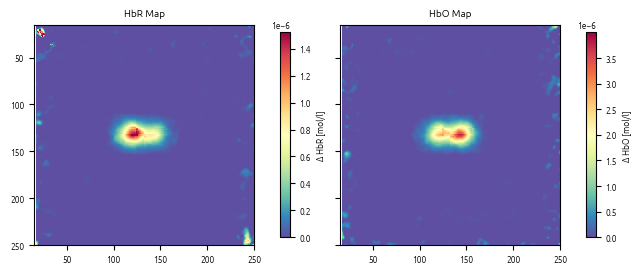

In [38]:
_Sep3colorMap = "Spectral_r"
    
font = {'family' : 'ubuntu',
        'weight' : 'regular',
        'size'   : 6}

mp.rc('font', **font)

if doTotMap:
        figSats, ((DesOxy, Oxy, Tot)) = plt.subplots(1, 3, sharex=True, sharey=True)
        font["size"] = 6
        mp.rc('font', **font)
else:
        figSats, ((DesOxy,Oxy)) = plt.subplots(1, 2, sharex=True, sharey=True)

sd = np.nanstd(desOxyMap_2D_filtered_Sep3)
median = np.nanmedian(desOxyMap_2D_filtered_Sep3)
vmax = median + maxDev * sd
vmin = 0

figDesOxy = DesOxy.imshow(desOxyMap_2D_filtered_Sep3, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c1 = figSats.colorbar(figDesOxy, ax=DesOxy, fraction=0.04, pad=0.1)
c1.set_label("Δ HbR [mol/l]")

sd = np.nanstd(OxyMap_2D_filtered_Sep3)
median = np.nanmedian(OxyMap_2D_filtered_Sep3)
vmax = median + maxDev * sd
vmin = 0


figOxy = Oxy.imshow(OxyMap_2D_filtered_Sep3, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c2 = figSats.colorbar(figOxy, ax=Oxy, fraction=0.04, pad=0.1)
c2.set_label("Δ HbO [mol/l]")

if doTotMap:
        TotMap_2D_Sep3 = desOxyMap_2D_filtered_Sep3 + OxyMap_2D_filtered_Sep3

        sd = np.nanstd(TotMap_2D_Sep3)
        median = np.nanmedian(TotMap_2D_Sep3)
        vmax = median + maxDev * sd
        vmin = 0


        figTot = Tot.imshow(TotMap_2D_Sep3, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
        c3 = figSats.colorbar(figTot, ax=Tot, fraction=0.04, pad=0.1)
        c3.set_label("Δ HbTot [mol/l]")

        Tot.set_title("Total HB HBMap")


DesOxy.set_title("HbR Map")

Oxy.set_title("HbO Map")

figSats.tight_layout()

figSats.savefig("MC2Incs_HbXMaps_MultiSep_Sep3.png", dpi=300)

0.8121451388247762 0.8357708985197907


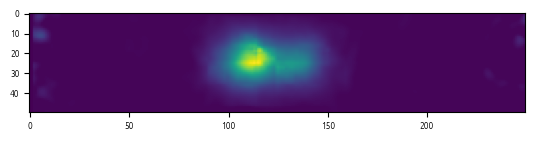

In [39]:
desOxyMap_2D_scaled_Sep3 = zoom(desOxyMap_2D_filtered_Sep3, 250/np.shape(desOxyMap_2D_filtered_Sep3)[0], order=1)
OxyMap_2D_scaled_Sep3= zoom(OxyMap_2D_filtered_Sep3, 250/np.shape(OxyMap_2D_filtered_Sep3)[0], order=1)

desOxyMap_2D_scaled_Sep3[desOxyMap_2D_scaled_Sep3<0]=0
desOxyMap_2D_scaled_Sep3[np.isnan(desOxyMap_2D_scaled_Sep3)]=np.nanmean(desOxyMap_2D_filtered_Sep3)

OxyMap_2D_scaled_Sep3[OxyMap_2D_scaled_Sep3<0]=0
OxyMap_2D_scaled_Sep3[np.isnan(OxyMap_2D_scaled_Sep3)]=np.nanmean(OxyMap_2D_filtered_Sep3)

plt.imshow(desOxyMap_2D_scaled_Sep3[100:150,:])

ssimOxy_Sep3 = ssim(GTHbO_Sep3[100:150,:], OxyMap_2D_scaled_Sep3[100:150,:], data_range=np.max(GTHbO_Sep3) - np.min(GTHbO_Sep3))
ssimDesOxy_Sep3 = ssim(GTHbR_Sep3[100:150,:], desOxyMap_2D_scaled_Sep3[100:150,:], data_range=np.max(GTHbR_Sep3) - np.min(GTHbR_Sep3))

ssimOxy_Sep3 = ssim(GTHbO_Sep3[100:150,:], OxyMap_2D_scaled_Sep3[100:150,:], data_range=np.max(GTHbO_Sep3) - np.min(GTHbO_Sep3))
ssimDesOxy_Sep3 = ssim(GTHbR_Sep3[100:150,:], desOxyMap_2D_scaled_Sep3[100:150,:], data_range=np.max(GTHbR_Sep3) - np.min(GTHbR_Sep3))

print(ssimOxy_Sep3, ssimDesOxy_Sep3)

4.6341209826337413e-07 1.867910154469985e-07


/tmp/ipykernel_26344/1842661820.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


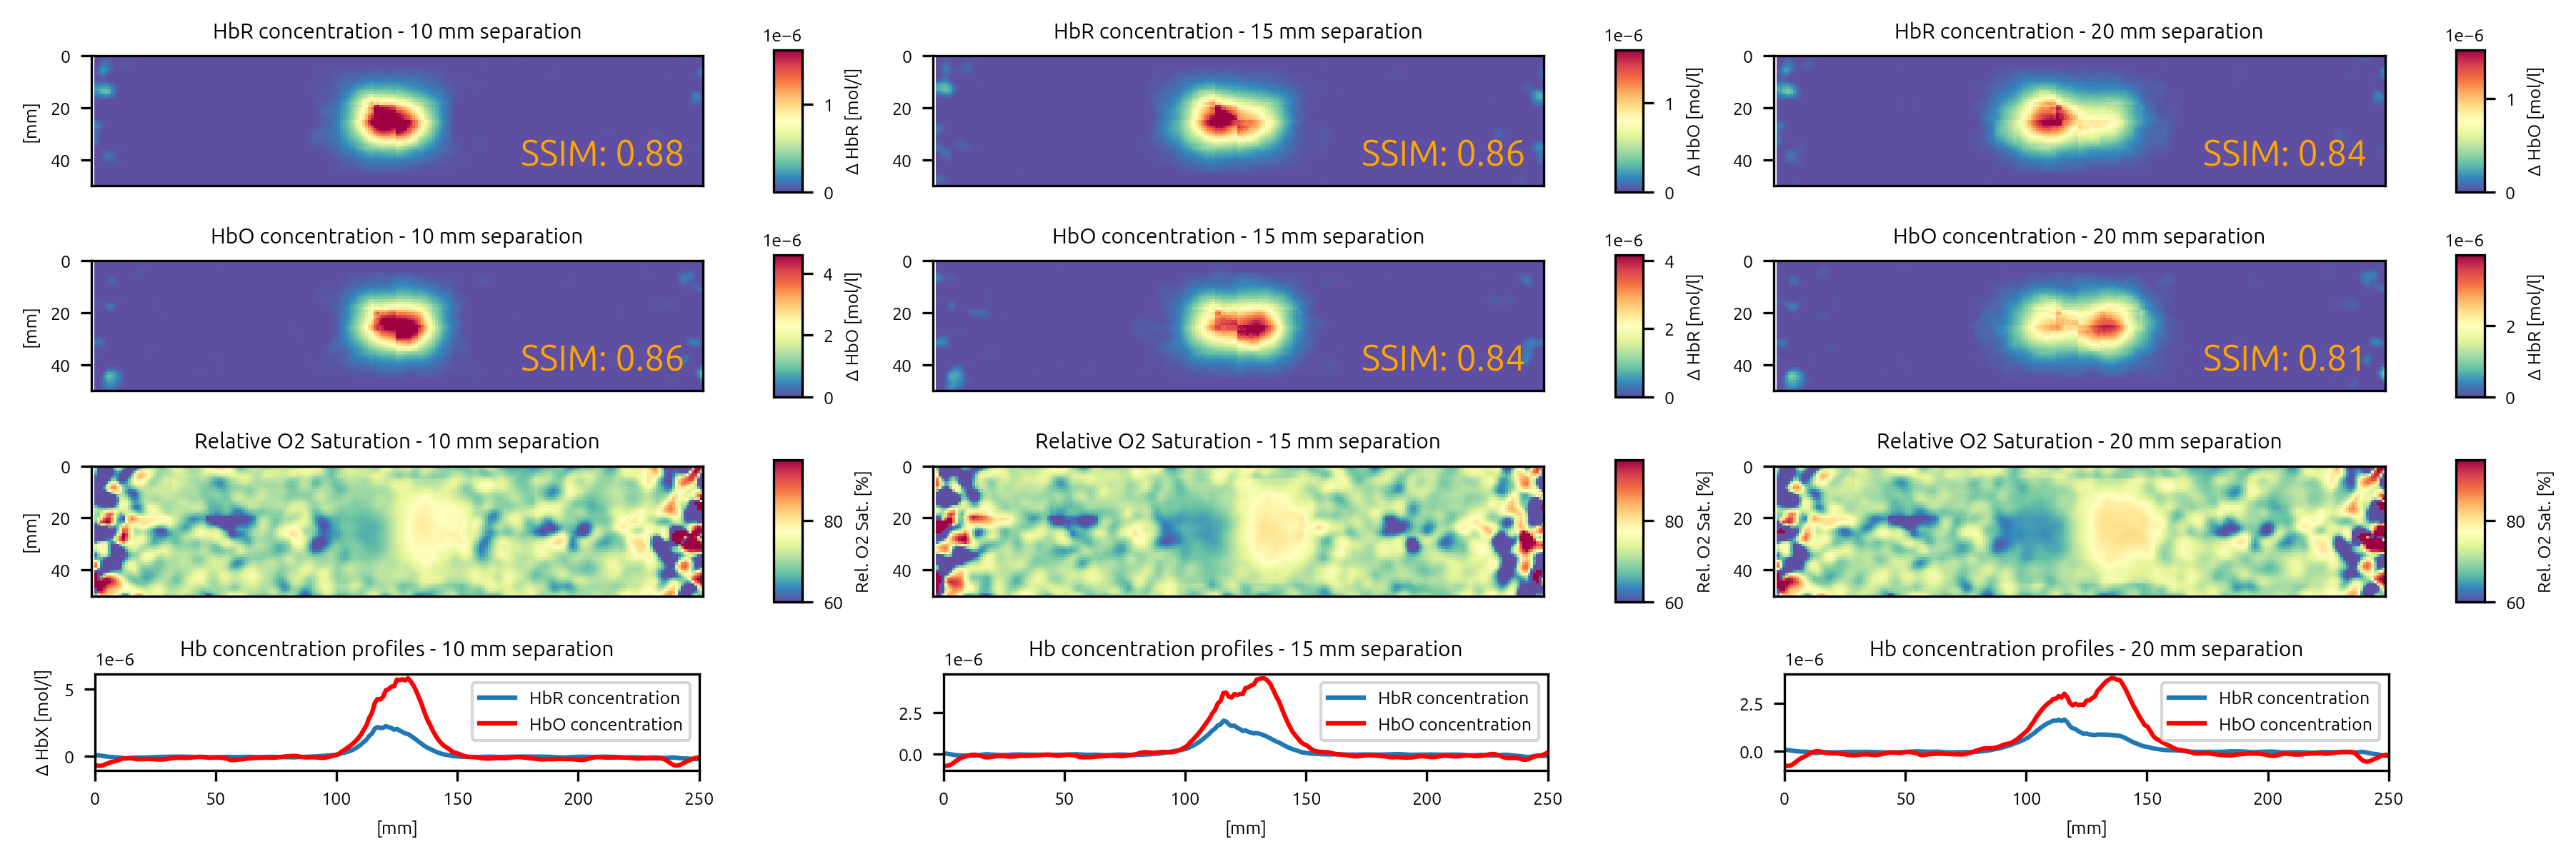

In [44]:
minValPos = 15
vertSize = 25

midVertPoint = int(np.shape(desOxyMap_2D_filtered_Sep2)[0]/2)

extent = [minValPos, 250, vertSize*2, 0]

if doSatMap:
    fig, axs = plt.subplots(3, 3, figsize=(12, 3), dpi=300)
else:
    fig, axs = plt.subplots(2, 3, figsize=(12, 3), dpi=300)

plt.subplots_adjust(hspace=0.1)

sd = np.nanstd(desOxyMap_2D_filtered_Sep1)
median = np.nanmedian(desOxyMap_2D_filtered_Sep1)
vmax = median + maxDev * sd
vmin = 0
imHbRSep1 = axs[0, 0].imshow(desOxyMap_2D_filtered_Sep1[midVertPoint-vertSize:midVertPoint +
                 vertSize, :], vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
cbarHbRSep1 = fig.colorbar(imHbRSep1, ax=axs[0, 0], fraction=0.04, pad=0.1, aspect=5)
cbarHbRSep1.set_label("Δ HbR [mol/l]")
axs[0, 0].text(180, 42, "SSIM: {0:.2f}".format(ssimDesOxy_Sep1), fontsize=12, c="orange")
axs[0, 0].set_title("HbR concentration - 10 mm separation")
axs[0, 0].set_ylabel("[mm]")
axs[0, 0].get_xaxis().set_visible(False)

sd = np.nanstd(desOxyMap_2D_filtered_Sep2)
median = np.nanmedian(desOxyMap_2D_filtered_Sep2)
vmax = median + maxDev * sd
vmin = 0
imHbRSep2 = axs[0, 1].imshow(desOxyMap_2D_filtered_Sep2[midVertPoint-vertSize:midVertPoint +
                 vertSize, :], vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
cbarHbRSep2 = fig.colorbar(imHbRSep2, ax=axs[0, 1], fraction=0.04, pad=0.1, aspect=5)
cbarHbRSep2.set_label("Δ HbO [mol/l]")
axs[0, 1].text(180, 42, "SSIM: {0:.2f}".format(ssimDesOxy_Sep2), fontsize=12, c="orange")
axs[0, 1].set_title("HbR concentration - 15 mm separation")
axs[0, 1].get_xaxis().set_visible(False)


sd = np.nanstd(desOxyMap_2D_filtered_Sep3)
median = np.nanmedian(desOxyMap_2D_filtered_Sep3)
vmax = median + maxDev * sd
vmin = 0
imHbRSep3= axs[0, 2].imshow(desOxyMap_2D_filtered_Sep3[midVertPoint-vertSize:midVertPoint +
                 vertSize, :], vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
cbarHbRSep3 = fig.colorbar(imHbRSep3, ax=axs[0, 2], fraction=0.04, pad=0.1, aspect=5)
cbarHbRSep3.set_label("Δ HbO [mol/l]")
axs[0, 2].text(180, 42, "SSIM: {0:.2f}".format(ssimDesOxy_Sep3), fontsize=12, c="orange")
axs[0, 2].set_title("HbR concentration - 20 mm separation")
axs[0, 2].get_xaxis().set_visible(False)


sd = np.nanstd(OxyMap_2D_filtered_Sep1)
median = np.nanmedian(OxyMap_2D_filtered_Sep1)
vmax = median + maxDev * sd
vmin = 0
imHbOSep1= axs[1, 0].imshow(OxyMap_2D_filtered_Sep1[midVertPoint-vertSize:midVertPoint +
                 vertSize, :], vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
cbarHbOSep1 = fig.colorbar(imHbOSep1, ax=axs[1, 0], fraction=0.04, pad=0.1, aspect=5)
cbarHbOSep1.set_label("Δ HbO [mol/l]")
axs[1, 0].text(180, 42, "SSIM: {0:.2f}".format(ssimOxy_Sep1), fontsize=12, c="orange")
axs[1, 0].set_title("HbO concentration - 10 mm separation")
axs[1, 0].set_ylabel("[mm]")
axs[1, 0].get_xaxis().set_visible(False)


sd = np.nanstd(OxyMap_2D_filtered_Sep2)
median = np.nanmedian(OxyMap_2D_filtered_Sep2)
vmax = median + maxDev * sd
vmin = 0
imHbOSep2 = axs[1, 1].imshow(OxyMap_2D_filtered_Sep2[midVertPoint-vertSize:midVertPoint +
                 vertSize, :], vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
cbarHbOSep2 = fig.colorbar(imHbOSep2, ax=axs[1, 1], fraction=0.04, pad=0.1, aspect=5)
cbarHbOSep2.set_label("Δ HbR [mol/l]")
axs[1, 1].text(180, 42, "SSIM: {0:.2f}".format(ssimOxy_Sep2), fontsize=12, c="orange")
axs[1, 1].set_title("HbO concentration - 15 mm separation")
axs[1, 1].get_xaxis().set_visible(False)


sd = np.nanstd(OxyMap_2D_filtered_Sep3)
median = np.nanmedian(OxyMap_2D_filtered_Sep3)
vmax = median + maxDev * sd
vmin = 0
imHbOSep3 = axs[1, 2].imshow(OxyMap_2D_filtered_Sep3[midVertPoint-vertSize:midVertPoint +
                 vertSize, :], vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
cbarHbOSep3 = fig.colorbar(imHbOSep3, ax=axs[1, 2], fraction=0.04, pad=0.1, aspect=5)
cbarHbOSep3.set_label("Δ HbR [mol/l]")
axs[1, 2].text(180, 42, "SSIM: {0:.2f}".format(ssimOxy_Sep3), fontsize=12, c="orange")
axs[1, 2].set_title("HbO concentration - 20 mm separation")
axs[1, 2].get_xaxis().set_visible(False)


if doSatMap:

    HbOminVal = np.abs(np.nanmin(aux.fftGauss(OxyMap_2D_filtered_Sep2, 10)[0]))
    HbRminVal = np.abs(np.nanmin(aux.fftGauss(desOxyMap_2D_filtered_Sep2, 10)[0]))
    print(HbOminVal, HbRminVal)

    O2SatMap_Sep1 = (OxyMap_2D_filtered_Sep1+HbOminVal)/((OxyMap_2D_filtered_Sep1 +
                                                          HbOminVal) + (desOxyMap_2D_filtered_Sep1+HbRminVal))
    O2SatMap_Sep2 = (OxyMap_2D_filtered_Sep2+HbOminVal)/((OxyMap_2D_filtered_Sep2 +
                                                          HbOminVal) + (desOxyMap_2D_filtered_Sep2+HbRminVal))
    O2SatMap_Sep3 = (OxyMap_2D_filtered_Sep3+HbOminVal)/((OxyMap_2D_filtered_Sep3 +
                                                          HbOminVal) + (desOxyMap_2D_filtered_Sep3+HbRminVal))
    vmax = 95
    vmin = 60
    imO2SatSep1= axs[2, 0].imshow(O2SatMap_Sep1[midVertPoint-vertSize:midVertPoint +
                                   vertSize, :]*100, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
    cbarO2SatSep1 = fig.colorbar(imO2SatSep1, ax=axs[2, 0], fraction=0.04, pad=0.1, aspect=5)
    cbarO2SatSep1.set_label("Rel. O2 Sat. [%]")
    axs[2, 0].set_title("Relative O2 Saturation - 10 mm separation")
    axs[2, 0].set_ylabel("[mm]")
    axs[2, 0].get_xaxis().set_visible(False)

    imO2SatSep2 = axs[2, 1].imshow(O2SatMap_Sep2[midVertPoint-vertSize:midVertPoint +
                                   vertSize, :]*100, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
    cbarO2SatSep2 = fig.colorbar(imO2SatSep2, ax=axs[2, 1], fraction=0.04, pad=0.1, aspect=5)
    cbarO2SatSep2.set_label("Rel. O2 Sat. [%]")
    axs[2, 1].set_title("Relative O2 Saturation - 15 mm separation")
    axs[2, 1].get_xaxis().set_visible(False)

    imO2SatSep3 = axs[2, 2].imshow(O2SatMap_Sep3[midVertPoint-vertSize:midVertPoint +
                                   vertSize, :]*100, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
    cbarO2SatSep3 = fig.colorbar(imO2SatSep3, ax=axs[2, 2], fraction=0.04, pad=0.1, aspect=5)
    cbarO2SatSep3.set_label("Rel. O2 Sat. [%]")
    axs[2, 2].set_title("Relative O2 Saturation - 20 mm separation")
    axs[2, 2].get_xaxis().set_visible(False)


prof_HbR_Sep1 = desOxyMap_2D_filtered_Sep1[midVertPoint, :]
prof_HbR_Sep2 = desOxyMap_2D_filtered_Sep2[midVertPoint, :]
prof_HbR_Sep3 = desOxyMap_2D_filtered_Sep3[midVertPoint, :]

prof_HbO_Sep1 = OxyMap_2D_filtered_Sep1[midVertPoint, :]
prof_HbO_Sep2 = OxyMap_2D_filtered_Sep2[midVertPoint, :]
prof_HbO_Sep3 = OxyMap_2D_filtered_Sep3[midVertPoint, :]

if doSatMap:
    axsNro = 3
else:
    axsNro = 2

x_scale = np.linspace(0, 250, np.shape(desOxyMap_2D_Sep2)[0])
    
plot1 = fig.add_axes([0.036, -0.2, 0.235, 0.15])
plot2 = fig.add_axes([0.366, -0.2, 0.235, 0.15])
plot3 = fig.add_axes([0.693, -0.2, 0.235, 0.15])

plot1.plot(x_scale, prof_HbR_Sep1, label="HbR concentration")
plot1.plot(x_scale, prof_HbO_Sep1, c="red", label="HbO concentration")
plot1.set_xlabel("[mm]")
plot1.set_ylabel("Δ HbX [mol/l]")
plot1.set_xlim(0, 250)
plot1.legend()
plot1.set_title("Hb concentration profiles - 10 mm separation")

plot2.plot(x_scale, prof_HbR_Sep2, label="HbR concentration")
plot2.plot(x_scale, prof_HbO_Sep2, c="red", label="HbO concentration")
plot2.set_xlabel("[mm]")
plot2.set_xlim(0, 250)
plot2.legend()
plot2.set_title("Hb concentration profiles - 15 mm separation")

plot3.plot(x_scale, prof_HbR_Sep3, label="HbR concentration")
plot3.plot(x_scale, prof_HbO_Sep3, c="red", label="HbO concentration")
plot3.set_xlabel("[mm]")
plot3.set_xlim(0, 250)
plot3.legend()
plot3.set_title("Hb concentration profiles - 20 mm separation")



""" 

axs[axsNro, 0].plot(x_scale, prof_HbR_Sep2, label="HbR concentration")
axs[axsNro, 0].plot(x_scale, prof_HbO_Sep2, c="red", label="HbO concentration")
axs[axsNro, 0].set_xlabel("[mm]")
axs[axsNro, 0].set_ylabel("Δ HbX [mol/l]")
axs[axsNro, 0].set_xlim(0, 250)
axs[axsNro, 0].legend()
axs[axsNro, 0].set_title("Hb concentration profiles - 10 mm separation")

axs[axsNro, 1].plot(x_scale, prof_HbR_Sep2, label="HbR concentration")
axs[axsNro, 1].plot(x_scale, prof_HbO_Sep2, c="red", label="HbO concentration")
axs[axsNro, 1].set_xlabel("[mm]")
axs[axsNro, 1].set_xlim(0, 250)
axs[axsNro, 1].legend()
axs[axsNro, 1].set_title("Hb concentration profiles - 15 mm separation")

axs[axsNro, 2].plot(x_scale, prof_HbR_Sep3, label="HbR concentration")
axs[axsNro, 2].plot(x_scale, prof_HbO_Sep3, c="red", label="HbO concentration")
axs[axsNro, 2].set_xlabel("[mm]")
axs[axsNro, 2].set_xlim(0, 250)
axs[axsNro, 2].legend()
axs[axsNro, 2].set_title("Hb concentration profiles - 20 mm separation")

 """
 
fig.tight_layout()

fig.savefig("MC2Incs_MultiSep.png", dpi=300)

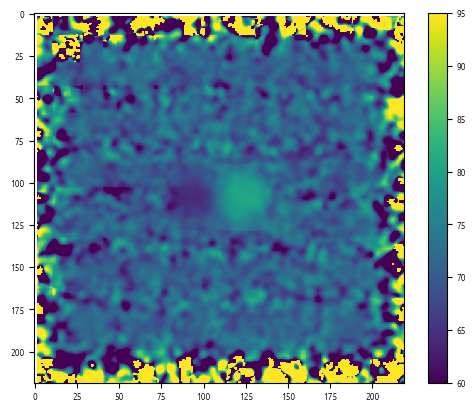

In [41]:
plt.figure()
plt.imshow(O2SatMap_Sep3*100, vmin=60,vmax=95)
plt.colorbar()
plt.show()